In [1]:
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
from matplotlib import pyplot as plt

# Download historical data
start_date = '2015-01-01'
end_date = '2022-12-31'
xom_data = yf.download('XOM', start=start_date, end=end_date)
cvx_data = yf.download('CVX', start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [2]:
# Use only Adjusted Close prices for this example
xom_close = xom_data['Adj Close']
cvx_close = cvx_data['Adj Close']

In [3]:
# Calculate the spread
xom_close_with_const = sm.add_constant(xom_close)
results = sm.OLS(cvx_close, xom_close_with_const).fit()

spread = results.resid

In [4]:
# Generate trading signals
mean = spread.rolling(60).mean()
std = spread.rolling(60).std()
zscore = (spread - mean) / std

In [5]:
# Create a DataFrame for the signals
signals = pd.DataFrame(index=xom_close.index)
signals['Long'] = 0.0
signals['Short'] = 0.0

In [6]:
# Create signals
signals['Long'][zscore > 2] = -1 # Short xom, Long cvx
signals['Short'][zscore > 2] = 1  
signals['Long'][zscore < -2] = 1  # Long xom, Short cvx
signals['Short'][zscore < -2] = -1 
signals['Long'][abs(zscore) < 0.5] = 0  # Clear positions when z-score is small
signals['Short'][abs(zscore) < 0.5] = 0  # Clear positions when z-score is small

In [7]:
# Calculate daily returns and strategy's performance
xom_returns = xom_close.pct_change()
cvx_returns = cvx_close.pct_change()

In [8]:
strategy_returns_long = signals['Long'].shift() * xom_returns
strategy_returns_short = signals['Short'].shift() * cvx_returns

strategy_returns = strategy_returns_long - strategy_returns_short

# Compute the cumulative returns, convert to percentage, and subtract 100% to start at 0%
cumulative_returns = (strategy_returns+1).cumprod() * 100 - 100

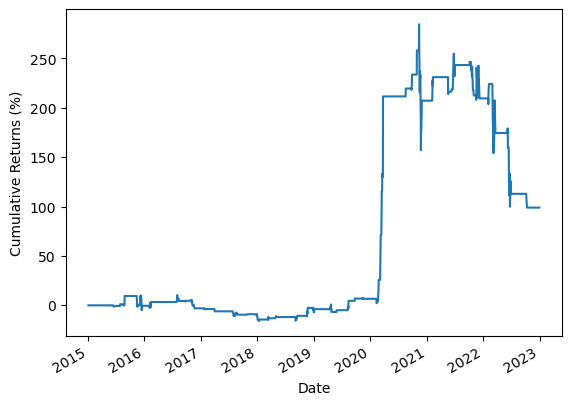

In [9]:
# Create a figure and an axis with matplotlib
fig, ax = plt.subplots()

# Plot the cumulative returns
cumulative_returns.plot(ax=ax)

# Set the y-axis label
ax.set_ylabel('Cumulative Returns (%)')

# Show the plot
plt.show()